In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Initialize SageMaker session
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'employee-attrition'

# For demonstration, we'll create synthetic data
def generate_synthetic_data(n_samples=1000):
    np.random.seed(42)
    data = {
        'Age': np.random.randint(22, 60, n_samples),
        'YearsAtCompany': np.random.randint(0, 20, n_samples),
        'Salary': np.random.randint(30000, 150000, n_samples),
        'JobSatisfaction': np.random.randint(1, 5, n_samples),
        'Department': np.random.choice(['HR', 'Sales', 'Engineering', 'Finance'], n_samples),
        'OverTime': np.random.choice(['Yes', 'No'], n_samples),
        'WorkLifeBalance': np.random.randint(1, 5, n_samples),
        'PerformanceRating': np.random.randint(1, 5, n_samples),
        'Attrition': np.random.choice(['Yes', 'No'], n_samples, p=[0.16, 0.84])  # 16% attrition rate
    }
    return pd.DataFrame(data)

# Generate and display sample data
df = generate_synthetic_data()
print(df.head())


/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
   Age  YearsAtCompany  Salary  JobSatisfaction   Department OverTime  \
0   50              16   86273                4  Engineering       No   
1   36              12  121878                1  Engineering      Yes   
2   29              15   34895                3        Sales      Yes   
3   42               7  149968                2           HR      Yes   
4   40              18  145700                3      Finance       No   

   WorkLifeBalance  PerformanceRating Attrition  
0                2                  4        No  
1                1                  1       Yes  
2                1                  4        No  
3                4                  1        No  
4                3                  3        No  


In [2]:
df.head(10)

,Age,YearsAtCompany,Salary,JobSatisfaction,Department,OverTime,WorkLifeBalance,PerformanceRating,Attrition
0,50,16,86273,4,Engineering,No,2,4,No
1,36,12,121878,1,Engineering,Yes,1,1,Yes
2,29,15,34895,3,Sales,Yes,1,4,No
3,42,7,149968,2,HR,Yes,4,1,No
4,40,18,145700,3,Finance,No,3,3,No
5,44,17,106559,1,Sales,No,2,4,No
6,32,0,40699,2,Finance,Yes,4,3,No
7,32,13,95061,3,Finance,No,1,2,Yes
8,45,18,39715,3,HR,Yes,1,3,Yes
9,57,14,49169,3,Engineering,No,3,2,No


               Age  YearsAtCompany         Salary  JobSatisfaction  \
count  1000.000000     1000.000000    1000.000000      1000.000000   
mean     40.947000        9.375000   87637.579000         2.468000   
std      11.160858        5.699725   34508.522126         1.133252   
min      22.000000        0.000000   30155.000000         1.000000   
25%      31.000000        4.000000   57483.500000         1.000000   
50%      42.000000        9.000000   86512.000000         2.000000   
75%      50.000000       14.000000  118580.750000         3.000000   
max      59.000000       19.000000  149968.000000         4.000000   

       WorkLifeBalance  PerformanceRating  
count      1000.000000        1000.000000  
mean          2.557000           2.516000  
std           1.115345           1.097702  
min           1.000000           1.000000  
25%           2.000000           2.000000  
50%           3.000000           3.000000  
75%           4.000000           3.000000  
max           4.0

[04/05/25 16:22:42] INFO     Using categorical units to plot a list of strings that are all         ]8;id=649315;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=170815;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=895462;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=860658;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

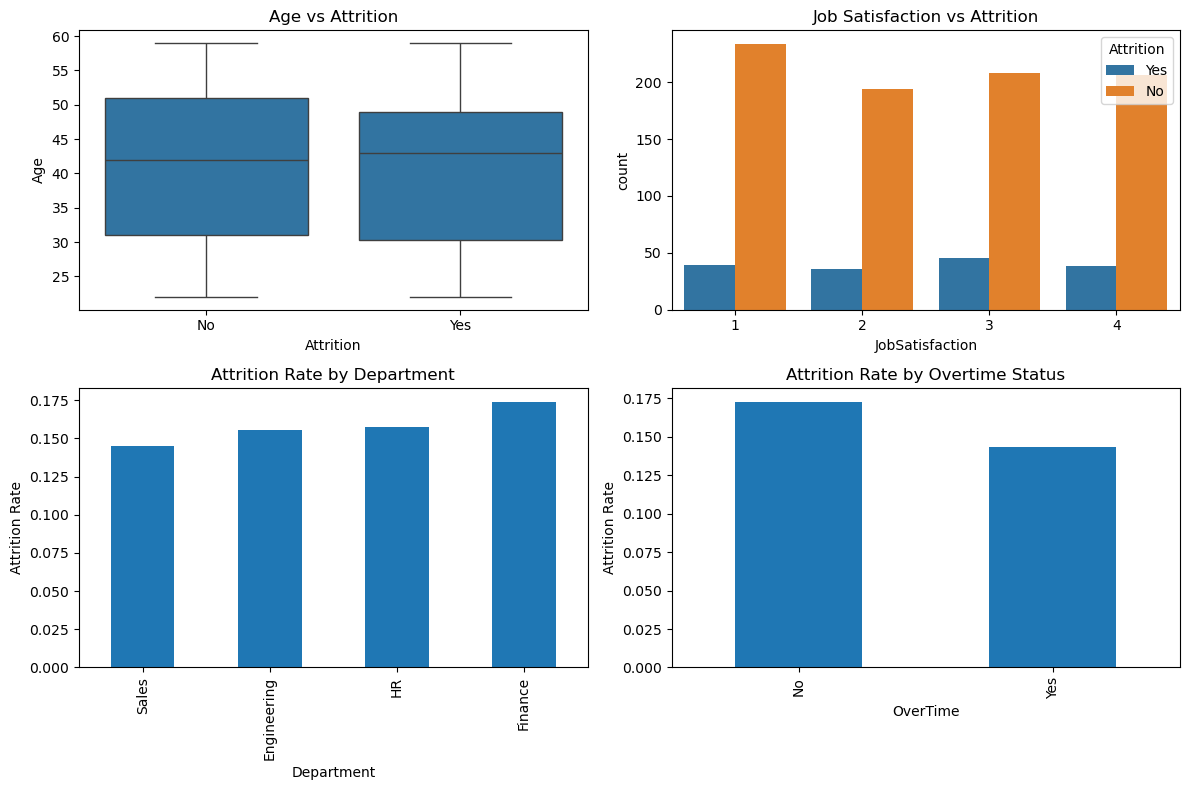

In [3]:
# Basic statistics
print(df.describe())

# Check class distribution
attrition_counts = df['Attrition'].value_counts()
print(f"Attrition distribution:\n{attrition_counts}")
print(f"Attrition rate: {attrition_counts['Yes'] / len(df):.2%}")

# Visualize key relationships
plt.figure(figsize=(12, 8))

# Age vs Attrition
plt.subplot(2, 2, 1)
sns.boxplot(x='Attrition', y='Age', data=df)
plt.title('Age vs Attrition')

# Job Satisfaction vs Attrition
plt.subplot(2, 2, 2)
sns.countplot(x='JobSatisfaction', hue='Attrition', data=df)
plt.title('Job Satisfaction vs Attrition')

# Department vs Attrition
plt.subplot(2, 2, 3)
dept_attrition = pd.crosstab(df['Department'], df['Attrition'], normalize='index')
dept_attrition['Yes'].sort_values().plot(kind='bar')
plt.title('Attrition Rate by Department')
plt.ylabel('Attrition Rate')

# Overtime vs Attrition
plt.subplot(2, 2, 4)
overtime_attrition = pd.crosstab(df['OverTime'], df['Attrition'], normalize='index')
overtime_attrition['Yes'].plot(kind='bar')
plt.title('Attrition Rate by Overtime Status')
plt.ylabel('Attrition Rate')

plt.tight_layout()
plt.show()


In [4]:
# Prepare features and target
X = df.drop('Attrition', axis=1)
y = (df['Attrition'] == 'Yes').astype(int)  # Convert to binary

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define preprocessing for numerical and categorical features
numerical_features = ['Age', 'YearsAtCompany', 'Salary', 'JobSatisfaction', 'WorkLifeBalance', 'PerformanceRating']
categorical_features = ['Department', 'OverTime']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to numpy arrays
train_features = X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed
test_features = X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed

print(f"Training data shape: {train_features.shape}")
print(f"Testing data shape: {test_features.shape}")

# Save the preprocessor for later use with new data
import joblib
joblib.dump(preprocessor, 'preprocessor.joblib')

# Format data for SageMaker XGBoost (CSV format with label in first column)
def format_for_xgboost(features, labels):
    """Format features and labels into CSV format for XGBoost."""
    if labels is not None:
        # For training/validation: label in first column
        data = np.hstack((labels.reshape(-1, 1), features))
    else:
        # For prediction: features only
        data = features
    return data

# Format training and test data
train_data = format_for_xgboost(train_features, y_train.values)
test_data = format_for_xgboost(test_features, y_test.values)

# Upload to S3
def upload_to_s3(data, bucket, prefix, filename):
    """Upload data to S3 in CSV format."""
    csv_buffer = io.StringIO()
    np.savetxt(csv_buffer, data, delimiter=',')
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, f"{prefix}/{filename}").put(Body=csv_buffer.getvalue())
    return f"s3://{bucket}/{prefix}/{filename}"

# Upload data to S3
train_s3_path = upload_to_s3(train_data, bucket, prefix, 'train.csv')
test_s3_path = upload_to_s3(test_data, bucket, prefix, 'test.csv')

print(f"Training data uploaded to: {train_s3_path}")
print(f"Test data uploaded to: {test_s3_path}")


Training data shape: (800, 10)
Testing data shape: (200, 10)
Training data uploaded to: s3://sagemaker-us-east-1-488176068240/employee-attrition/train.csv
Test data uploaded to: s3://sagemaker-us-east-1-488176068240/employee-attrition/test.csv


In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator

# Get the container image for XGBoost
container = sagemaker.image_uris.retrieve('xgboost', session.boto_region_name, '1.5-1')

# Set up the estimator
xgb = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=session
)

# Set hyperparameters
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective='binary:logistic',
    num_round=100,
    verbosity=1
)

# Define data channels
train_input = sagemaker.inputs.TrainingInput(
    train_s3_path,
    content_type='text/csv',
    distribution='FullyReplicated'
)

validation_input = sagemaker.inputs.TrainingInput(
    test_s3_path,
    content_type='text/csv',
    distribution='FullyReplicated'
)

data_channels = {
    'train': train_input,
    'validation': validation_input
}

[04/05/25 16:34:50] INFO     Ignoring unnecessary instance type: None.                            ]8;id=586902;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=363092;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [6]:
# Train the model
xgb.fit(inputs=data_channels)

[04/05/25 16:34:55] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=78988;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=389825;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=173564;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=125023;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-05-16-34-55-726                                             

2025-04-05 16:34:57 Starting - Starting the training job...
..25-04-05 16:35:12 Starting - Preparing the instances for training.
.....04-05 16:36:00 Downloading - Downloading the training image.
/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-04-05 16:36:55.629 ip-10-0-242-55.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-04-05 16:36:55.652 ip-10-0-242-55.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-04-05:16:36:56:INFO] Imported framework sagemaker_xgboost_container.training
[2025-04-05:16:36:56:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2025-04-05:16:36:56:INFO] No GPUs detected (normal if no gpus installed)
[2025-04-05:16:36:56:INFO] Running 

In [7]:
# Deploy the model to an endpoint
xgb_predictor = xgb.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=sagemaker.serializers.CSVSerializer()
)

[04/05/25 16:42:05] INFO     Creating model with name: sagemaker-xgboost-2025-04-05-16-42-05-534    ]8;id=674207;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=580840;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/05/25 16:42:06] INFO     Creating endpoint-config with name                                     ]8;id=314363;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=625780;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5889\5889]8;;\
                             sagemaker-xgboost-2025-04-05-16-42-05-534                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-04-05-16-42-05-534  ]8;id=455739;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=576712;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4711\4711]8;;\

-------!

In [11]:
# Get the endpoint name
endpoint_name = xgb_predictor.endpoint_name
print(f"Endpoint Name: {endpoint_name}")



Endpoint Name: sagemaker-xgboost-2025-04-05-16-42-05-534


In [17]:
# Method 1: Using the SageMaker Python SDK
def predict_with_sagemaker_sdk(data, predictor):
    """Make predictions using the SageMaker Python SDK."""
    # Ensure data is in the right format for XGBoost built-in algorithm
    if isinstance(data, pd.DataFrame):
        # Preprocess the data
        preprocessor = joblib.load('preprocessor.joblib')
        processed_data = preprocessor.transform(data)
        if hasattr(processed_data, 'toarray'):
            processed_data = processed_data.toarray()
        
        # Convert to CSV format - XGBoost built-in algorithm expects CSV with no header
        csv_data = io.StringIO()
        np.savetxt(csv_data, processed_data, delimiter=',')
        
        # Make prediction
        response = predictor.predict(csv_data.getvalue())
        
        # Parse the response - built-in XGBoost may return multiple lines
        if isinstance(response, bytes):
            response_str = response.decode('utf-8')
        else:
            response_str = response
            
        # Split by lines and parse each line as JSON
        predictions = []
        for line in response_str.strip().split('\n'):
            if line:  # Skip empty lines
                predictions.append(float(line))  # XGBoost returns one float per line
                
        return np.array(predictions)
    else:
        raise ValueError("Input must be a pandas DataFrame")
            
    # Convert to CSV string - XGBoost built-in algorithm expects CSV with no header
    csv_buffer = io.StringIO()
    np.savetxt(csv_buffer, processed_data, delimiter=',')
    csv_data = csv_buffer.getvalue()
    
    
    # Create a boto3 client
    runtime_client = boto3.client('sagemaker-runtime')
    
    # Make the prediction
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='text/csv',
        Body=csv_data
    )
    
    # Parse the response - built-in XGBoost may return multiple lines
    response_str = response['Body'].read().decode('utf-8')
    
    # Split by lines and parse each line
    predictions = []
    for line in response_str.strip().split('\n'):
        if line:  # Skip empty lines
            predictions.append(float(line))  # XGBoost returns one float per line
            
    return np.array(predictions)



In [18]:
# Create sample employee data for prediction
sample_employees = pd.DataFrame({
    'Age': [35, 42, 29, 55, 38],
    'YearsAtCompany': [3, 15, 1, 20, 7],
    'Salary': [85000, 120000, 65000, 130000, 95000],
    'JobSatisfaction': [3, 4, 2, 5, 3],
    'Department': ['Sales', 'Engineering', 'HR', 'Finance', 'Engineering'],
    'OverTime': ['Yes', 'No', 'Yes', 'No', 'No'],
    'WorkLifeBalance': [2, 4, 2, 3, 3],
    'PerformanceRating': [3, 5, 3, 4, 4]
})


In [19]:
# Make predictions using SageMaker SDK
sdk_predictions = predict_with_sagemaker_sdk(sample_employees, xgb_predictor)
sdk_attrition_risk = (sdk_predictions > 0.5).astype(int)


In [20]:
# Display results
results = pd.DataFrame({
    'Employee': range(1, len(sample_employees) + 1),
    'Age': sample_employees['Age'],
    'Department': sample_employees['Department'],
    'YearsAtCompany': sample_employees['YearsAtCompany'],
    'OverTime': sample_employees['OverTime'],
    'Attrition_Probability': sdk_predictions,
    'Attrition_Risk': ['High' if risk == 1 else 'Low' for risk in sdk_attrition_risk]
})


In [22]:
print("\nEmployee Attrition Prediction Results:")
print(results)



Employee Attrition Prediction Results:
   Employee  Age   Department  YearsAtCompany OverTime  Attrition_Probability  \
0         1   35        Sales               3      Yes               0.072712   
1         2   42  Engineering              15       No               0.205359   
2         3   29           HR               1      Yes               0.180682   
3         4   55      Finance              20       No               0.075997   
4         5   38  Engineering               7       No               0.354622   

  Attrition_Risk  
0            Low  
1            Low  
2            Low  
3            Low  
4            Low  


In [ ]:
# Clean up resources when done
print("\nCleaning up resources...")
xgb_predictor.delete_endpoint()
print("Endpoint deleted successfully")
